# Computational Geometry

Computational geometry is a classical field at the intersection of computing and mathematics. A large range of problems rely on dealing with spatial data to make decisions or obtain detailed information. Examples include pattern recognition (e.g. facial recognition or collision avoidance), mapping (e.g. route planning), computer vision (e.g. 3D reconstruction) and physical simulation (e.g. modelling of a complex ocean basin). This notebook/lecture is a (very) short introduction to this broad and varied topic.

Computational geometry problems require us to define geometrical objects like points, lines and polygons on the computer and then answer queries about them. 

## Point-in-polygon

A simple, but computationally interesting, starting example is a point-in-polygon problem, i.e. we might want to know if a certain point lies within a known polygon. Applications include deciding if your cursor is within a certain application window or if an aircraft is within the airspace of a particular country.

Let's set up such a situation in Python

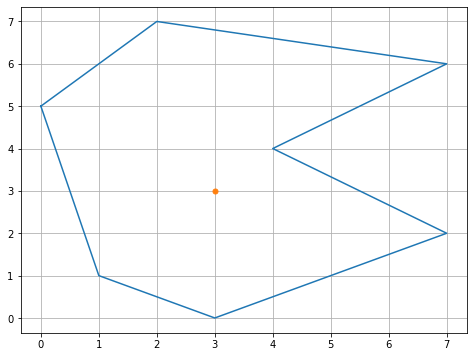

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Make an array of points for the polygon
poly1 = np.array([[0, 5], [1, 1], [3, 0],
               [7, 2],[4,4],[7, 6], [2, 7],[0, 5]])

# A point to check
point1 = np.array([3,3])


# Make a plot
plt.figure(figsize=(8,6))
plt.plot(poly1[:,0],poly1[:,1])
plt.plot(point1[0],point1[1],'.',ms='10')
plt.grid()
plt.show()

By eye, this problem is trivial, but formulating the question into one which can be parsed by the computer requires a little thought. 

There are a couple of ways this can be done, a point is inside the polygon if

* a ray originating at the point intersects the polygon boundary an odd number of times (odd *crossing number*)

or

* the curve definining the polygon travels around the point at least once (non-zero *winding number*)

We can try writing our own function which implements the winding number version. If we assume the polygon is convex and its points are sensibly ordered, we can choose an arbitrary vertex to start, traverse the edges, summing the angles created by the point of interest and the pairs of points at each end of the edge.

If an edge is defined by points $\mathbf{x}_i$ and $\mathbf{x}_{i+1},$ and $\mathbf{x}_p$ is the point of interest the angle we require is given by

$\mathbf{v}_{i} = \mathbf{x}_i-\mathbf{x}_p$

$\mathbf{v}_{i+1} = \mathbf{x}_{i+1}-\mathbf{x}_p$

$$\theta_i = \sin^{-1}\frac{|\mathbf{v}_{i}\times \mathbf{v}_{i+1}|}{|\mathbf{v}_{i}||\mathbf{v}_{i+1}|} $$

Then the *winding number* can then be defined as

$$ W =  \frac{\sum_i^N\theta_i}{2\pi}  $$

if $W>1,$ $\mathbf{x}_p$ is inside the polygon.


In [10]:
def angle(x1,x2,x3): # Computes theta
    v1 = x1 - x2  
    v2 = x3 - x2 
    mag1 = np.sqrt(v1[0]**2+v1[1]**2)
    mag2 = np.sqrt(v2[0]**2+v2[1]**2)
    return np.arcsin((v1[0]*v2[1]-v1[1]*v2[0])/(mag1*mag2))

def winding(polyPoints,point):
    N = len(polyPoints)
    totalAngle = 0.0

    for i in range(N-1):
        totalAngle += angle(polyPoints[i],point,polyPoints[i+1])

    return ((totalAngle))/(2*np.pi) # account for clockwise/anticlockwise rotation and rounding error


Test on our example above

In [11]:
winding(poly1,np.array([3,3]))

1.0

A different test case

winding number =  -1.0


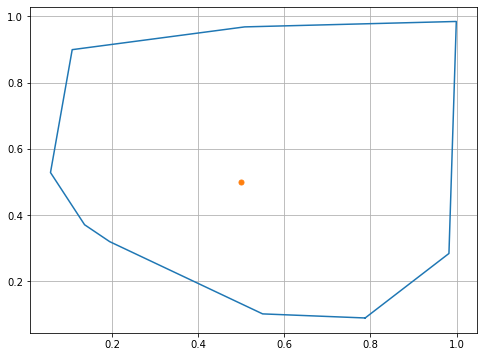

In [12]:
poly2 = np.array(
      [[0.78758964, 0.08941681],
       [0.54969572, 0.10175701],
       [0.19493093, 0.31976052],
       [0.13663129, 0.37082234],
       [0.05754   , 0.52834017],
       [0.10790758, 0.89923077],
       [0.50819293, 0.96794738],
       [0.9991026 , 0.98431721],
       [0.98201591, 0.28409295],
       [0.78758964, 0.08941681]])

point2 = np.array([0.5,0.5])

print('winding number = ',winding(poly2,point2))

# Make a plot
plt.figure(figsize=(8,6))
plt.plot(poly2[:,0],poly2[:,1])
plt.plot(point2[0],point2[1],'.',ms='10')
plt.grid()
plt.show()

This algorithm has some issues, mainly because it uses `arcsin` to get the angle which is expensive to execute and prone to *edge cases*, e.g. here rounding can create an argument for `arcsin` which is greater than 1. 

In [13]:
winding(poly1,np.array([4,4]))

/var/folders/l_/nz3b162x51n6xt0rvbk43ypc0000gq/T/ipykernel_28277/3215083744.py:6: RuntimeWarning: invalid value encountered in true_divide
  return np.arcsin((v1[0]*v2[1]-v1[1]*v2[0])/(mag1*mag2))
/var/folders/l_/nz3b162x51n6xt0rvbk43ypc0000gq/T/ipykernel_28277/3215083744.py:6: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((v1[0]*v2[1]-v1[1]*v2[0])/(mag1*mag2))


nan

Let us attempt a version of the crossing number method. In this case we will again cycle through polygon edges, but now check if the *horizontal* line through the point intersects the edge and increment the crossing number if so.

In [14]:
def crossing(polyPoints,point):
    N = len(polyPoints)
    cn = 0.0

    for i in range(N-1):
        if(polyPoints[i][0]<point[0] and polyPoints[i][1]<point[1] and polyPoints[i+1][1]>point[1]): # upward crossing
            cn += 1
        elif(polyPoints[i][0]<point[0] and polyPoints[i][1]>point[1] and polyPoints[i+1][1]<point[1]): # downward crossing
            cn += 1
    return cn

print('crossing number 1 = ', crossing(poly1,point1))
print('crossing number 2 = ', crossing(poly2,point2))

print('crossing number fail = ', crossing(poly1,[0,0]))

crossing number 1 =  1.0
crossing number 2 =  1.0
crossing number fail =  0.0


Now there are still certain issues with the crossing number approach, if the polygon is not simple (has holes or overlaps itself) the crossing number can fail. There is an algorithm which computes the winding number by crossings giving us the best of both worlds (see [here](https://web.archive.org/web/20130126163405/http://geomalgorithms.com/a03-_inclusion.html) to investigate more for yourself). A simplified version for convex polygons tests to see if the point lies always to the same side of each edge. Taking an edge $\mathbf{v}_i$ we can determine if one turns through a positive or negative angle when moving to $\mathbf{x}_p$ by evaluating

$$ \phi_i = \mathbf{v}_i \times (\mathbf{x}_p - \mathbf{x}_{i+1}), $$

i.e. 

* $\mathbf{x}_p$ is left of $\mathbf{v}_i$ if $\phi_i>0,$
* $\mathbf{x}_p$ is right of $\mathbf{v}_i$ if $\phi_i<0,$
* $\mathbf{x}_p$ is *on* $\mathbf{v}_i$ if $\phi_i=0.$

So if *all* $\phi_i>0$ *or all* $\phi_i<0$ then the point is inside the polygon (accounting for whether the vertices are ordered clockwise or anticlockwise). 

In [25]:
def pip(polyPoints,point):
    N = len(polyPoints)-1
    phi = np.zeros(N)

    
    for i in range(N):
        v1 = polyPoints[i+1] - polyPoints[i]  
        v2 = point - polyPoints[i+1]
        phi[i] =  v1[0]*v2[1] - v1[1]*v2[0]
 
    return (phi>0).all() or (phi<0).all()

In [27]:
pip(poly2,[0,0])

False

### Sympy

There are a few modules/libraries in Python for exploring geometric problems. 

`sympy` has a [set of functions](https://docs.sympy.org/latest/modules/geometry/index.html) for investigating and experimenting with geometrical problems, for instance the point-in-polygon problem is answered by

In [42]:
import sympy as sp
from sympy import Point, Polygon

p = Polygon((0, 5), (1, 1), (3, 0),
               (7, 2),(4,4),(7, 6), (2, 7),(0, 5))

p.encloses_point(Point(3, 3))

True

There are plenty of other functions, but we leave it for your own investigation for now.

## Delauny Triangulation

When dealing with spatial data many problems require the segmentation of a certain space (for instance for physical modelling) or require some connectivity of a set of data points (for instance for route planning). One method to create such a description is the Delauny Triangulation which takes a set of points and builds a set of triangles with those points as vertices such that no point lies *inside* the circumcircle of any triangle (i.e. they only lie on the edge). This maximises the angles of the triangles, reducing as much as possible triangles with one or more very acute angles (called [sliver triangles](https://en.wikipedia.org/wiki/Glossary_of_computer_graphics#sliver_triangle) in computer graphics).

The algorithms to obtain such triangulations are quite involved and sophisticated, here we just introduce an application using Python.

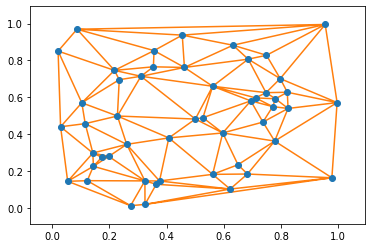

In [36]:
from scipy.spatial import Delaunay, delaunay_plot_2d

rng = np.random.default_rng()
points = rng.random((50, 2))
tri = Delaunay(points)

delaunay_plot_2d(tri)
plt.show()

## Convex Hull

The *union of simplices* of the Delauny triangulation of a set of points (i.e. the outer edge, or union of edges belonging to only one triangle) is known as the *convex hull*. The convex hull of a set of points is an important concept in computational geometry. For instance many pattern recognition algorithms will identify a certain set of points associated with a feature and the convex hull will give its boundary. There are a number of algorithms for obtaining the convex hull, in fact one such algorithm, the "Graham scan algorithm" will be the subject of this week's laboratory exercise, see the additional video with the description and pseudocode for the algorithm which you will implement. 

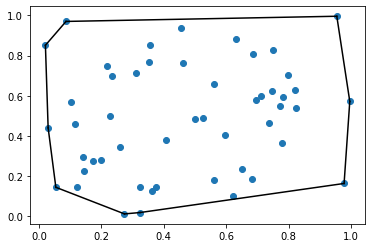

In [45]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points)

plt.figure()
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.show()